In [1]:
import pandas as pd
import altair as alt
import re
import os
from textblob import TextBlob
from bs4 import BeautifulSoup
import nltk
import arrow
from IPython.display import display, HTML, FileLink, clear_output
nltk.download('stopwords')
nltk.download('punkt')
stopwords = nltk.corpus.stopwords.words('english')
alt.renderers.enable('notebook')
alt.data_transformers.enable('json')

[nltk_data] Downloading package stopwords to /Users/tim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/tim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


DataTransformerRegistry.enable('json')

In [2]:
def make_word_sets(df, words=[], position=None, distance=None):
    dfs = []
    if position and distance:
        if position == 'before':
            distance = 0 - distance
        elif position == 'after':
            distance = distance - 1
    if words:
        for word in words:
            if position and distance:
                new_df = df.loc[df[position].apply(lambda x: x[distance] == word)].copy()
            elif position:
                new_df = df.loc[df[position].apply(lambda x: word in x)].copy()
            elif distance:
                new_df = df.loc[df['before'].apply(lambda x: x[0 - distance] == word) | df['after'].apply(lambda x: x[distance - 1] == word)].copy()
            else:
                new_df = df.loc[df['before'].apply(lambda x: word in x) | df['after'].apply(lambda x: word in x)].copy()
            new_df['word'] = word
            dfs.append(new_df[['date', 'id', 'word', 'kwic']])
    elif position and distance:
        new_df = df.copy()
        new_df['word']= new_df.apply(lambda row: row[position][distance], axis=1)
        dfs.append(new_df[['date', 'id', 'word', 'kwic']])
    return pd.concat(dfs, ignore_index=True)

## Results file from Historic Hansard

In [3]:
df = pd.read_csv('hansard_aliens.csv', parse_dates=['date'])
df.head()

,date,debate,speaker,speaker_id,house,parliament,context,speech_url
0,1920-11-04,ALIENS REGISTRATION BILL: Second Reading,Mr POYNTON,KYD,hofreps,8,contained in those regulations. The purpose o...,https://historichansard.net/hofreps/1920/19201...
1,1920-11-10,ALIENS REGISTRATION BILL,Mr CONSIDINE,K4F,hofreps,8,"**aliens**, particularly those of the working...",https://historichansard.net/hofreps/1920/19201...
2,1920-11-10,ALIENS REGISTRATION BILL,Mr TUDOR,KWL,hofreps,8,"year. According to the definition clause, Wa...",https://historichansard.net/hofreps/1920/19201...
3,1920-11-16,ALIENS REGISTRATION BILL,Mr WEST,KZA,hofreps,8,more generous in dealing with the admission o...,https://historichansard.net/hofreps/1920/19201...
4,1920-11-16,ALIENS REGISTRATION BILL,Mr CONSIDINE,K4F,hofreps,8,drastic action. There are other means of iden...,https://historichansard.net/hofreps/1920/19201...


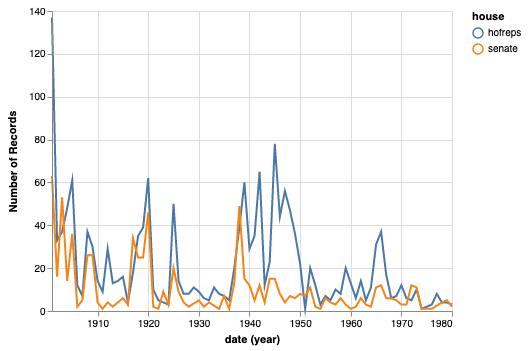

In [4]:
alt.Chart(df).mark_line().encode(
    x='year(date):T',
    y='count()',
    color='house'
)

## Load words data

In [5]:
# Load aliens data
aliens_df = pd.read_csv('hansard-aliens-words-5.csv', parse_dates=['date'])
aliens_df['before'] = aliens_df['before'].str.lower().str.split('|')
aliens_df['after'] = aliens_df['after'].str.lower().str.split('|')
aliens_df.dropna(inplace=True)
aliens_df.head()

,id,date,kwic,before,after
0,19150514_reps_6_76.xml,1915-05-14,"t, issued n proclamation defining the position...","[proclamation, defining, the, position, of]","[that, is, of, german, subjects]"
1,19150514_reps_6_76.xml,1915-05-14,means. He says -that this deals with deposits...,"[this, deals, with, deposits, by]","[posits, by, aliens, or, by]"
2,19410626_reps_16_167.xml,1941-06-26,intelligence authorities interned him with en...,"[authorities, interned, him, with, enemy]","[and, refused, to, offer, any]"
3,19410626_reps_16_167.xml,1941-06-26,now he placed in a concentration camp among en...,"[a, concentration, camp, among, enemy]","[for, no, reason, known, to]"
4,19120801_reps_4_65.xml,1912-08-01,"cess of that allowed by the Act, or through be...","[the, act, or, through, being]","[c, but, it, is, certain]"


In [6]:
# Load immigrants data
immigrants_df = pd.read_csv('hansard-immigrants-words-5.csv', parse_dates=['date'])
immigrants_df['before'] = immigrants_df['before'].str.lower().str.split('|')
immigrants_df['after'] = immigrants_df['after'].str.lower().str.split('|')
immigrants_df.dropna(inplace=True)
immigrants_df.head()

,id,date,kwic,before,after
0,19300326_senate_12_123.xml,1930-03-26,en them; and (3) The Commonwealth should see t...,"[the, commonwealth, should, see, that]","[accepted, under, a, scheme, were]"
1,19670411_reps_26_hor54.xml,1967-04-11,f the increase has come from migration and 99%...,"[from, migration, and, 99, of]","[are, single, people, or, people]"
2,19560502_senate_22_s7.xml,1956-05-02,population. The Government has brought out m...,"[government, has, brought, out, many]","[more, than, ever, before, but]"
3,19570326_reps_22_hor14.xml,1957-03-26,ve continually urged that we increase the flow...,"[we, increase, the, flow, of]","[that, would, act, they, said]"
4,19570326_reps_22_hor14.xml,1957-03-26,should be an immediate reduction of the intake...,"[reduction, of, the, intake, of]","[in, other, words, the, labour]"


## Overall frequencies

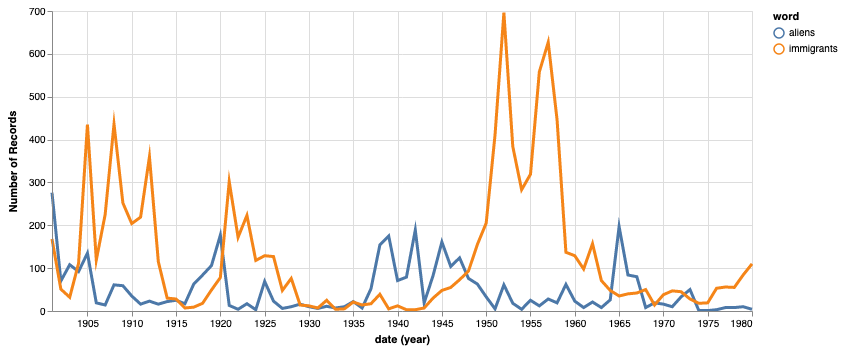

In [7]:
c1 = alt.Chart(aliens_df).mark_line(strokeWidth=3).encode(
    x='year(date):T',
    y='count():Q',
    color='word:N'
).transform_calculate(
    word = '"aliens"'
).properties(
    width=700
)

c2 = alt.Chart(immigrants_df).mark_line(strokeWidth=3).encode(
    x='year(date):T',
    y='count():Q',
    color='word:N'
).transform_calculate(
    word = '"immigrants"'
).properties(
    width=700
)

c1 + c2

## Words before...

In [8]:
words_before_aliens = make_word_sets(df=aliens_df, position='before', distance=1)
words_before_aliens = words_before_aliens.loc[words_before_aliens['word'].apply(lambda x: (x.lower() not in stopwords) and len(x) > 2)]
words_before_immigrants = make_word_sets(df=immigrants_df, position='before', distance=1)
words_before_immigrants = words_before_immigrants.loc[words_before_immigrants['word'].apply(lambda x: (x.lower() not in stopwords) and len(x) > 2)]

In [9]:
words_before_aliens['word'].value_counts()[:25]

enemy            295
coloured         288
undesirable       60
aliens            53
000               33
unnaturalized     29
many              29
white             27
civil             25
friendly          23
refugee           21
naturalized       21
certain           20
asiatic           19
security          19
registered        18
upon              15
eligible          15
stateless         13
marry             12
require           10
become            10
interned          10
european           9
exclude            9
Name: word, dtype: int64

In [10]:
words_before_immigrants['word'].value_counts()[:25]

british        507
000            276
prohibited     237
undesirable    126
contract       125
many           124
assisted       122
intending      115
desirable      114
european       104
bringing       101
bring          100
illegal         87
suitable        80
prospective     79
italian         78
attract         77
immigrants      61
foreign         47
german          47
best            41
attracting      39
among           33
want            32
white           30
Name: word, dtype: int64

In [11]:
alien_words = make_word_sets(df=aliens_df, words=['enemy', 'coloured', 'undesirable', 'white',  'friendly', 'refugee', 'asiatic'], position='before', distance=1)

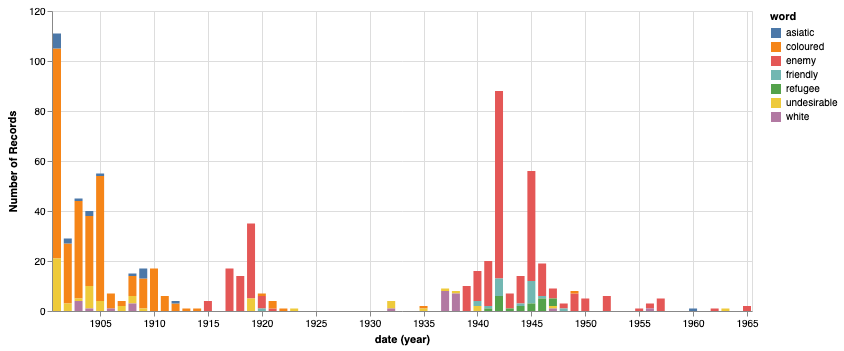

In [12]:
alt.Chart(alien_words).mark_bar(size=8).encode(
    x='year(date):T',
    y=alt.Y('count():Q'),
    color='word'
).properties(
    width=700
)

In [13]:
immigrant_words = make_word_sets(df=immigrants_df, words=['prohibited', 'undesirable', 'contract', 'assisted', 'intending', 'desirable', 'white', 'illegal', 'suitable'], position='before')

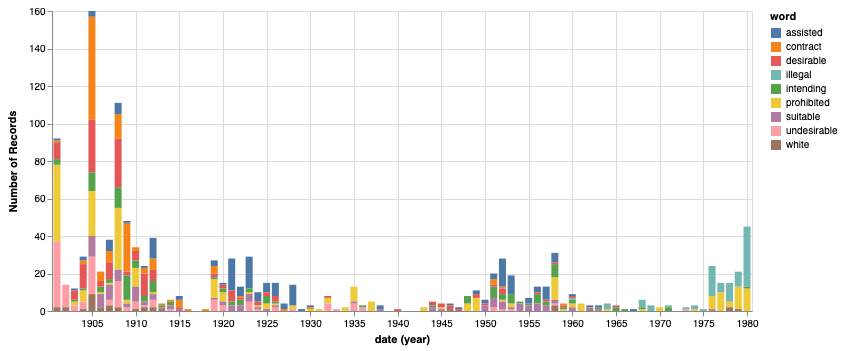

In [14]:
alt.Chart(immigrant_words).mark_bar(size=7).encode(
    x='year(date):T',
    y=alt.Y('count():Q'),
    color='word'
).properties(width=700)

In [15]:
immigrant_origin_words = make_word_sets(df=immigrants_df, words=['british', 'jewish', 'european', 'italian', 'chinese', 'irish', 'english', 'german', 'japanese', 'scottish', 'scotch', 'dutch', 'asian', 'american', 'indian', 'maltese', 'russian'], position='before', distance=1)

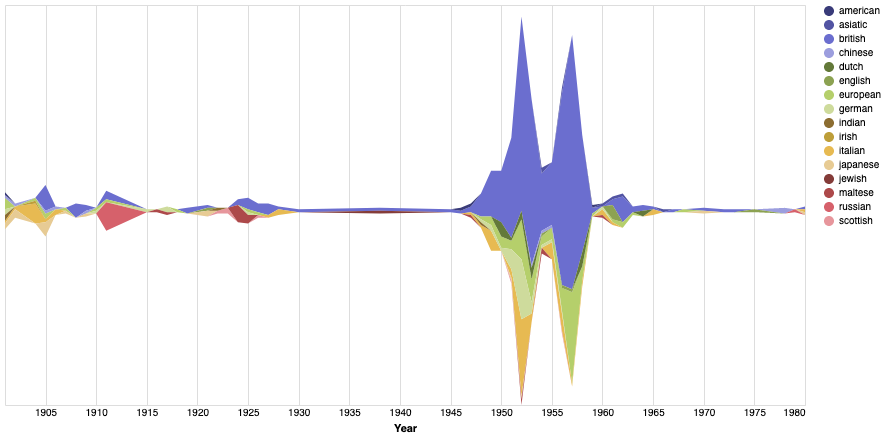

In [16]:
alt.Chart(immigrant_origin_words.replace('scotch', 'scottish').replace('asian', 'asiatic')).mark_area().encode(
    alt.X('year(date):T',
        axis=alt.Axis(format='%Y', domain=False, tickSize=0), title='Year'
    ),
    alt.Y('count():Q', stack='center', axis=None, title='Frequency'),
    alt.Color('word:N', scale=alt.Scale(scheme='category20b'), title=None)
).properties(width=800, height=400)

In [17]:
df_word_set2 = make_word_sets(immigrants_df, words=['intake', 'influx', 'flow', 'numbers', 'thousands'])

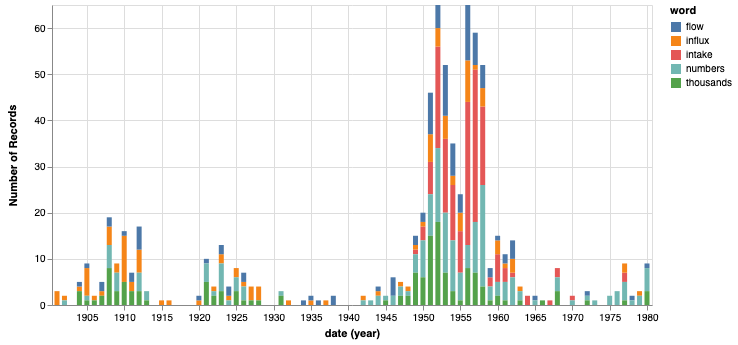

In [18]:
alt.Chart(df_word_set2).mark_bar().encode(
    x='year(date):T',
    y='count()',
    color='word'
).properties(width=600)